

# Structure of Empirical Networks

## Introduction

So far, we've introduced several ways to quantify and visualize the properties of networks. Many of our examples have been small, and we've used the same network several times to illustrate important points. In this chapter, we'll address an important empirical question:

> What are some of the properties of *real* networks more broadly?

Of course, there's no simple answer to this question: we observe network data sets across a wide variety of domains, and many of them have different properties. For our purposes today, we'll look at a sample of four networks, including two familiar ones provided with NetworkX and two new ones:

- `twitch`: A network of mutual friends on the Twitch streaming platform. The data set was collected by @musae.
- `chameleon`: A network of Wikipedia pages on topics related to chameleons (yes, the animal). An edge exists between two nodes if the corresponding Wikipedia pages link to each other. The data set was collected by @musae.
- `karate`: The Zachary Karate Club social network [@zachary1977information], which is packaged with NetworkX.
- `les_mis`: A network of character interactions in the novel *Les Miserables* by Victor Hugo, also packaged with NetworkX.
- `org_1` and `org_2`: Two anonymized Facebook social networks of employees in two different mediums-sized organizations. This data was collected and published by @fire2012organization. Nodes are employees and edges are  friendships. This data set was accessed from the [website of Michael Fire](https://data4goodlab.github.io/MichaelFire/#section3) and discovered via the [Colorado Index of Complex Networks](https://icon.colorado.edu/) (ICON).


Our first task is to download these data sets and read them in as NetworkX graph objects, which we do in the hidden cell below.

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np
from scipy.special import factorial
import pandas as pd
import random

# acquire twitch data
url = "https://raw.githubusercontent.com/benedekrozemberczki/MUSAE/master/input/edges/ENGB_edges.csv"
edges = pd.read_csv(url)
G_twitch = nx.from_pandas_edgelist(edges, "from", "to", create_using=nx.Graph)

# acquire chameleon data
url = "https://raw.githubusercontent.com/benedekrozemberczki/MUSAE/master/input/edges/chameleon_edges.csv"
edges = pd.read_csv(url)
G_chameleon = nx.from_pandas_edgelist(edges, "id1", "id2", create_using=nx.Graph)

# acquire organizations data

url = "https://raw.githubusercontent.com/network-science-notes/network-science-notes.github.io/refs/heads/main/data/organization-social-networks/M1Anonymized.csv"
edges = pd.read_csv(url, header=None)
G_org_1 = nx.from_pandas_edgelist(edges, 0, 1, create_using=nx.Graph)

url = "https://raw.githubusercontent.com/network-science-notes/network-science-notes.github.io/refs/heads/main/data/organization-social-networks/M2Anonymized.csv"
edges = pd.read_csv(url, header=None)
G_org_2 = nx.from_pandas_edgelist(edges, 0, 1, create_using=nx.Graph)

# two built-in networkx data sets.
G_karate = nx.karate_club_graph()
G_les_mis = nx.les_miserables_graph()

Now that we have our data sets, we could in principle go ahead and compute various measurements and properties. However, a fundamental principle in measuring networks is to *compare*. If we say that a network has a high value of some measurement $X$, then the correct reply is:

> High compared to what?

There are many reasonable answers to this question, and we'll explore several of them when we come to the study of random graphs. For now, we are going to compare each of our real networks to a *synthetic random graph with a similar degree sequence*. [Technically, we are using a model that reproduces the degree sequence *approximately and in expectation*. This model is often called the Chung-Lu model and is due to @chung2002connected.]{.aside}

The following code constructs a random synthetic counterpart graph for each of our empirical graphs. It then adds all of these to a dictionary so that we can easily access both the real and synthetic graphs later.

In [2]:
def unweight(G):
    for source, target in G.edges():
        G[source][target]['weight'] = 1

def random_counterpart(G):
    degrees = [deg for (node, deg) in G.degree()]
    G_random = nx.expected_degree_graph(degrees, selfloops=False)
    G_random.remove_edges_from(nx.selfloop_edges(G_random))
    return G_random

def add_to_dataset_dict(dataset_dict, G, name):
    unweight(G)
    dataset_dict[name] = {
        "graph" : G,
        "random" : random_counterpart(G)
    }

Now we'll prepare our dictionary of data sets.

In [3]:
dataset_dict = {}

for graph, name in {G_twitch: "twitch",
                    G_chameleon: "chameleon",
                    G_karate: "karate",
                    G_les_mis: "les_mis",
                    G_org_1: "org_1",
                    G_org_2: "org_2"}.items():

    add_to_dataset_dict(dataset_dict, graph, name)

To help us compute and compare measurements on these graphs, we'll define the following function which will manage these computations and organize the result as a table. This function takes as an argument a function `fun` which accepts a graph as an input and returns a scalar value.

In [4]:
def compute_metric(fun = lambda x: 0, compare = True):
    print("Data Set" + " " * 10 + "Real", end = "")
    if compare:
            print(" " * 10 + "Random")
    else:
        print()
    print("-" * 22, end = "")
    if compare:
        print("-"*18)
    else:
        print()
    for data_set in dataset_dict:
        print(data_set + " " * (14 - len(data_set)) + f"{fun(dataset_dict[data_set]['graph']):>8.2f}", end = "")
        if compare:
            print(" " * (8) + f"{fun(dataset_dict[data_set]['random']):>8.2f}")
        else:
            print()

## Node and Edge Counts

Let's start with something simple: how many nodes and edges are in each graph?

In [5]:
print(f"Number of nodes")
compute_metric(lambda x: x.number_of_nodes())

Number of nodes
Data Set          Real          Random
----------------------------------------
twitch         7126.00         7126.00
chameleon      2277.00         2277.00
karate           34.00           34.00
les_mis          77.00           77.00
org_1          1429.00         1429.00
org_2          3862.00         3862.00


In [6]:
print(f"Number of edges")
compute_metric(lambda x: x.number_of_edges())

Number of edges
Data Set          Real          Random
----------------------------------------
twitch        35324.00        35628.00
chameleon     31421.00        31361.00
karate           78.00           55.00
les_mis         254.00          234.00
org_1         19357.00        19111.00
org_2         87324.00        87251.00


Although the number of nodes agree exactly in the real and random networks, there are some small discrepancies in the edge counts. This is due to the fact that our procedure for constructing random graphs (a) only preserves the degrees *in expectation* rather than exactly and (b) can create some self-loops, which get discarded.


## Clustering Coefficient

Now that we have our experimental setup in place, let's move on to something more complex. Take a moment and think of two of your friends, whom we'll call $A$ and $B$. Are $A$ and $B$ themselves friends with each other? If they are, then we say that you, $A$, and $B$ together form a *triangle* or *triad* in the social network.

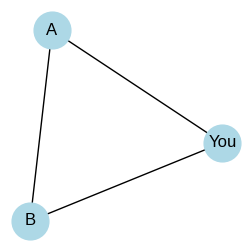

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
G = nx.Graph()
G.add_edges_from([("A", "B"), ("A", "You"), ("B", "You")])
nx.draw(G, with_labels = True, node_size = 700, node_color = "lightblue", ax = ax)

A stylized fact about many networksis that triangles like these are common. In order to validate this stylized fact, we need to (a) determine how to measure the prevalence of triangles and (b) compare the value of this measure on our real networks to that of their random counterparts.

There are many possible measures of the prevalence of triangles, but here we will use the *transitivity*: the fraction of all *possible* triangles that are present in the network. We define a *possible triangle* as a path of length 3 like that shown in @fig-wedge; the addition of just a single edge would turn this path into a triangle.

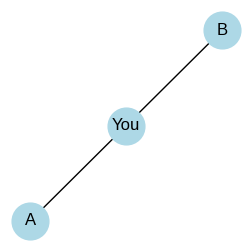

In [8]:

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
G = nx.Graph()
G.add_edges_from([ ("A", "You"), ("B", "You")])
nx.draw(G, with_labels = True, node_size = 700, node_color = "lightblue", ax = ax)

It is possible to show that the number of possible triangles with node $i$ in the middle is $k_i(k_i - 1)/2$, where $k_i$ is the degree of node $i$. The transitivity is then the ratio of the number of triangles to the number of possible triangles.

The formula for transitivity is therefore: [The factor of $\frac{1}{2}$ for the number of possible triangles has cancelled with the factor of $\frac{1}{2}$ needed to adjust the numerator to reflect the fact that we can travel a triangle in either direction]{.aside}

$$
\begin{aligned}
    T(G) = \frac{\mathrm{trace}(\mathbf{A}^3)}{\sum_{i} k_i(k_i - 1)}
\end{aligned}
$$



Here, $\mathbf{A}$ is the adjacency matrix of $G$ and $k_i$ is the degree of node $i$.

Let's write a function to compute the transitivity of a graph.

In [11]:
def my_transitivity(G):
  # triangles
  A = nx.adjacency_matrix(G).toarray()
  num_triangles = np.trace(A@A@A)

  # wedges
  degrees = A.sum(axis = 0)
  num_wedges = np.sum(degrees*(degrees - 1))

  return num_triangles/num_wedges

Let's compare our function to the built-in function supplied by NetworkX.

In [12]:
print(my_transitivity(G_karate))
print(nx.transitivity(G_karate))

0.2556818181818182
0.2556818181818182


Looks good! We'll move forward with the NetworkX version, as it is substantially faster on larger graphs.

In [15]:
print(f"transitivity")
compute_metric(nx.transitivity)

transitivity
Data Set          Real          Random
----------------------------------------
twitch            0.04            0.03
chameleon         0.31            0.12
karate            0.26            0.32
les_mis           0.50            0.20
org_1             0.26            0.08
org_2             0.23            0.02


We observe that the `chameleon` and `les_mis` graphs appear to have substantially greater transitivity than their random counterparts, while both `karate` and `twitch` have similar transitivity to their random counterparts. The two organizational social networks have much higher transitivity than their random counterparts as well. Under this comparison, *some* networks indeed display very high transitivity. Indeed, it's thought that most social networks have high transitivity.

When interpreting these results, it's helpful to explicitly describe *what* is captured by the random counterpart when stating our conclusions. Recall that we constructed the random counterpart graphs to approximately preserve the degree sequence of the original data graph, while being otherwise random. Our conclusion could therefore be that graphs like `chameleon`, `les_mis`, or the two organizational graphs *have higher values of the transitivity than can be explained by their degree sequences alone*.

## Connected Components

What about the number of connected components in the network?

In [17]:
compute_metric(lambda x: len(list(nx.connected_components(x))))

Data Set          Real          Random
----------------------------------------
twitch            1.00          594.00
chameleon         1.00           73.00
karate            1.00            6.00
les_mis           1.00            9.00
org_1             1.00            7.00
org_2             1.00            1.00


Recall that we've engineered all of our real networks to have only one connected component, filtering if necessary. On the other hand, the random networks tend to have multiple connected components.

Would it be fair to say that real networks are more connected than would be expected at random? Some caution is required here. Many researchers collect network data using methods that are especially likely to produce connected networks. For example, *snowball sampling* in study design refers to the method of recruiting participants for a survey or other instrument by asking people to recommend their friends. Since they can't recommend people they don't know, the snowball sample collected from an individual is always connected. Similarly, data sets like the `chameleon` data set are constructed by following links from one Wikipedia page to another. This method always produces a connected network as well. So, while it is true that many network data sets contain a single connected component, this is often an artifact of data collection rather than a fundamental property of the network.

## Degree-Degree Correlations

We have constructed random counterpart networks that have similar degree sequences to the real networks we are studying. Networks, however, can have interesting degree structures beyond just the degree sequence. One such structure is the *degree-assortativity*. The degree assortativity measures the extent to which nodes of similar degree are connected to each other. There are several ways to measure degree assortativity, but the most common one (due to @newman2018networks) has formula

$$
\begin{aligned}
    C = \frac{\sum_{(u,v) \in G} k_u k_v - \frac{1}{m}\left(\sum_{(u,v) \in G}  k_u\right)^2}{\sum_{(u,v) \in G} k_u^2 - \frac{1}{m}\left(\sum_{(u,v) \in G}  k_u\right)^2}\;.
\end{aligned}
$$

[If you are familiar with probability and statistics, this formula is equivalent to $C = \frac{\mathrm{cov}(K_1,K_2)}{\sqrt{\mathrm{var}(K_1)\mathrm{var}(K_2)}}$, where $K_1$ and $K_2$ are the degrees of the nodes at the ends of an edge selected uniformly at random from $G$. This is also the Pearson correlation coefficient between $K_1$ and $K_2$.]{.aside}

An *assortative* network (with high assortativity) is one in which nodes of high degree tend to connect to each other frequently. A *disassortative* network (with negative assortativity) is one in which nodes of high degree tend to connect to nodes of low degree. Let's take a look at the assortativity values in our networks:

In [18]:
compute_metric(nx.degree_assortativity_coefficient)

Data Set          Real          Random
----------------------------------------
twitch           -0.12           -0.04
chameleon        -0.20           -0.06
karate           -0.48           -0.12
les_mis          -0.17           -0.02
org_1             0.11           -0.02
org_2             0.09           -0.00


The two organizational social networks are slightly assortative: employees have a tendency to associate with those who are similarly connected to them. On the other hand, the remaining networks are disassortative, even in comparison to their random counterparts.

Disassortativity is a common feature of many networks, and it is often attributed to the presence of *hubs* in the network. Hubs are nodes with very high degree, and they tend to connect to many other nodes. Since there are only a few hubs, they are more likely to connect to nodes of low degree than to other hubs.

## Shortest Path Lengths

In a famous study, Stanley @milgram1967small [^1] asked participants to ensure that a letter reached a target person, whom they did not know, in a US city. However, the participants were only allowed to send the letter to someone they knew on a first-name basis. That person could then send the letter to another person they knew on a first-name basis, and so on, until the letter was delivered (or lost). Perhaps surprisingly, many participants were able to reach the target person in only a few steps, on average. This experiment is the origin of the famous phrase *six degrees of separation*: in many social networks, most individuals are separated by relatively few links, even when the network is very large.  

[^1]: Yes, [*that* Milgram](https://en.wikipedia.org/wiki/Milgram_experiment) [@milgram1963behavioral].


To test this in our networks, we'll compute the length of the shortest path between a pair of nodes, averaged across all possible pairs. This quantity isn't defined for the random counterpart networks that have multiple disconnected components (why?), and so we'll stick to calculating it on the real-world networks.

In [19]:
compute_metric(lambda x: nx.average_shortest_path_length(x), compare = False)

Data Set          Real
----------------------
twitch            3.68
chameleon         3.56
karate            2.41
les_mis           2.64
org_1             3.04
org_2             2.76


Indeed, despite some of these networks having thousands of nodes and edges, the average shortest path length does not exceed 4 links. We'll consider some theoretical models that aim to explain this phenomenon later in the course.

## Degree Distributions

So far in our investigations, we've focused on comparing networks to randomized counterparts that have similar degrees. But what if we want to look at the degrees themselves? The way we most frequently do this is by analyzing the degree distribution, which we can think of as a histogram of the node degrees. Let's look at the degree histogram for the karate club network:

[Text(0.5, 0, 'Degree'), Text(0, 0.5, 'Density')]

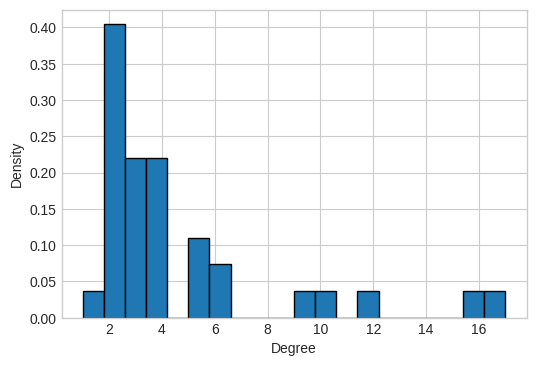

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
deg = np.array([deg for i, deg in nx.degree(G_karate)])
hist = ax.hist(deg, bins = 20, density = True,  edgecolor = "black")
ax.set(xlabel = "Degree", ylabel = "Density")

We see that in the karate club network, there are a small number of nodes with very high degree. This kind of pattern is common in social networks. [We often say that the degree distribution is "heavy-tailed" when we mean to express the idea that there are a small number of very high-degree nodes.]{.aside}

Heavy-tailed distributions are difficult to visualize on linear scales, so we often instead plot them on log-log scales. The helper functions in the hidden code cell below implement what is called "logarithmic binning" and plot the resulting log-binned histograms on logarithmic axes:

In [21]:
def log_binned_histogram(degree_sequence, interval = 5, num_bins = 20):
    hist, bins = np.histogram(degree_sequence, bins = min(int(len(degree_sequence)/interval), num_bins))
    bins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(degree_sequence, bins = bins)
    binwidths = bins[1:] - bins[:-1]
    hist = hist / binwidths
    p = hist/hist.sum()
    return bins[:-1], p

def plot_degree_distribution(G, ax, **kwargs):

    deg_seq = np.array([deg for i, deg in nx.degree(G)])
    x, p = log_binned_histogram(deg_seq, **kwargs)
    ax.scatter(x, p,  facecolors='none', edgecolors =  'cornflowerblue', linewidth = 2, label = "Data")
    ax.loglog()


We can use these functions to plot the degree distribution of the networks we've previously studied:

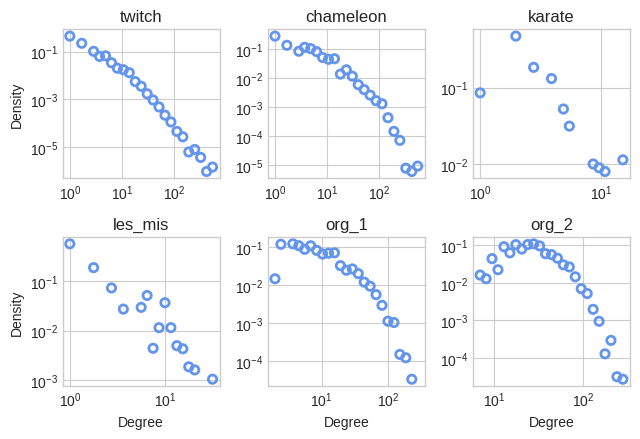

In [22]:

fig, ax = plt.subplots(2, 3, figsize = (6.5, 4.5))

for i, name in enumerate(dataset_dict):

    plot_degree_distribution(dataset_dict[name]["graph"], ax.ravel()[i], interval = 1, num_bins = 25)
    ax.ravel()[i].set_title(name)

    if i % 3 == 0:
        ax.ravel()[i].set(ylabel = "Density")
    if i >= 3:
        ax.ravel()[i].set(xlabel = "Degree")

plt.tight_layout()

Comparing our different data sets, we can observe a range of shapes in the degree distributions. One especially interesting feature of degree distributions that has received a LOT of attention in the networks literature (@holmeRareEverywherePerspectives2019) is the roughly linear behavior on log-log axes displayed, among our data sets, by the `twitch` graph. If we remember that both the horizontal and vertical axes are logarithmic, apparent linearity on these log-log axes corresponds to the equation

$$
\begin{aligned}
    \log p_k = \log C - \gamma \log k\;,
\end{aligned}
$$

where $p_k$ is the proportion of nodes with degree $k$ and $C$ and $\gamma$ are constants. Exponentiating both sides gives

$$
\begin{aligned}
    p_k = C k^{-\gamma}\;,
\end{aligned}
$${#eq-power-law}

which is called a *power law* for degree distribution. We say that the degree distribution of the `twitch` network appears to obey a power law *in the tail* of the distribution, since the linear behavior is only visible for larger values of $k$.

### Statistical Properties of Power Laws

Power laws have interesting statistical properties which depend on the value of the exponent $\gamma$. Let's try computing a few *moments* of the distribution: [For mathematical simplicity, we are ignoring nodes of degree 0.]{.aside}

$$
\begin{aligned}
    \mu_{0} &= \sum_{k = 1}^\infty p_k = C \sum_{k = 1}^\infty k^{-\gamma} \\
    \mu_{1} &= \sum_{k = 1}^\infty p_k k = C \sum_{k = 1}^\infty k^{1-\gamma} \\
    \mu_{2} &= \sum_{k = 1}^\infty p_k k^2 = C \sum_{k = 1}^\infty k^{2-\gamma}\;.
\end{aligned}
$$

We can recognize $\mu_0$ as the sum of all the probabilities in the degree distribution, $\mu_1$ as the mean of the degree distribution (i.e. the expected degree) and $\mu_2$ as the expected squared degree, which is used in the formula for variance $\mathrm{var}(K) = \mu_2 - \mu_1^2$. Recalling that the series $\sum_{k = 1}^\infty k^{-p}$ converges if and only if $p > 1$, we see that:

- $\mu_0$ is finite if and only if $\gamma > 1$. This means that $\gamma > 1$ is required for the power law to describe a valid probability distribution over degrees.
- $\mu_1$ is finite if and only if $\gamma > 2$.
- $\mu_2$ is finite if and only if $\gamma > 3$.

Many empirical networks have degree distributions that are well-approximated by power laws with $\gamma \in (2, 3)$. In this regime, the mean is finite but the variance is infinite. This means that the distribution can generate samples which are arbitrarily far from the mean, as in the `twitch` network: although the *mean* degree is `{python} float(np.round(np.mean([deg for i, deg in nx.degree(G_twitch)])))`, the *maximum* degree is `{python} int(np.max([deg for i, deg in nx.degree(G_twitch)]))`.




### Purported Universality of Power Laws

@barabasiEmergenceScalingRandom1999 made the first published that power-law degree distributions are very common in real-world networks. This initial paper has since been cited over 46,000 times (as of August 2024). *Many* subsequent studies have fit power-law tails to degree distributions in empirical networks across social, technological, and biological domains. [@clausetPowerLawDistributionsEmpirical2009,  @broidoScalefreeNetworksAre2019 and @holmeRareEverywherePerspectives2019 provide some review and references for these claims.]{.aside}
The idea that power laws are common in real-world networks is sometimes called the "scale-free hypothesis." Part of the appeal of this hypothesis comes from statistical physics and complexity science, where power law distributions are common signatures of self-organizing systems.





## References